In [1]:
import os
import torch
import torchvision
import random
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
from collections import Counter
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")

print("Path to dataset files:", path)

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\asus\.cache\kagglehub\datasets\asdasdasasdas\garbage-classification\versions\2


In [3]:
data_dir = r"C:\Users\asus\OneDrive\Desktop\garbage_classification"
classes = os.listdir(data_dir)
print(classes)

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [4]:
transformations = transforms.Compose(
    [transforms.Resize ((224, 224)), transforms.ToTensor()])
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

dataset = ImageFolder(data_dir, transform=transformations)

In [5]:
labels = dataset.targets

count_per_class = Counter(labels)

for i, class_name in enumerate(dataset.classes):
    print(f"{class_name:<10} → {count_per_class[i]} samples")

print("="*25)

total_samples = sum(count_per_class.values())
print("Total samples:", total_samples)

battery    → 945 samples
biological → 985 samples
brown-glass → 607 samples
cardboard  → 891 samples
clothes    → 5325 samples
green-glass → 629 samples
metal      → 769 samples
paper      → 1050 samples
plastic    → 865 samples
shoes      → 1977 samples
trash      → 697 samples
white-glass → 775 samples
Total samples: 15515


In [6]:
weight = total_samples / (len(dataset.classes) * torch.tensor(list(count_per_class.values()), dtype=torch.float))
weight


tensor([1.3682, 1.3126, 2.1300, 1.4511, 0.2428, 2.0555, 1.6813, 1.2313, 1.4947,
        0.6540, 1.8550, 1.6683])

**Loading and Sampling the data**

In [7]:
torch.manual_seed(42)
total = len(dataset)

train_size = int(0.70 * total)
val_size = int(0.15 * total)
test_size = total - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

print("The lenght of the train data :",len(train_ds))
print("The lenght of the val data : ",len(val_ds))
print("The lenght of the test data :", len(test_ds))

The lenght of the train data : 10860
The lenght of the val data :  2327
The lenght of the test data : 2328


In [8]:
batch_size = 32

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

val_loader = DataLoader(val_ds, batch_size=batch_size,
                        shuffle=False, pin_memory=True)

test_loader = DataLoader(test_ds, batch_size=batch_size,
                         shuffle=False, pin_memory=True)

In [9]:
for i , batches in train_loader:
  print (i.shape)
  break

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([32, 3, 224, 224])


**Visulize Batches**

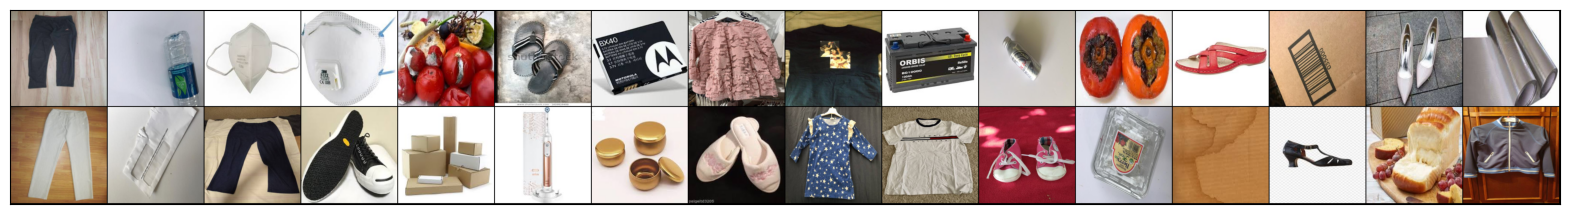

In [10]:
from torchvision.utils import make_grid


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  
        loss = F.cross_entropy(out, labels)  
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result, is_best=False):
        msg = (
            f"Epoch {epoch} | "
            f"Train Acc: {result['train_acc']:.4f} | "
            f"Train Loss: {result['train_loss']:.4f} | "
            f"Val Loss: {result['val_loss']:.4f} | "
            f"Val Acc: {result['val_acc']:.4f}"
        )
        if is_best:
            msg += "  <-- Saving best model "
        print(msg)

In [12]:
import torch.nn as nn
import torchvision.models as models


class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.resnet50(pretrained=True)

        
        num_ftrs = self.network.fc.in_features

       
        self.network.fc = nn.Sequential(
            nn.Dropout(p=0.2),               
            nn.Linear(num_ftrs, len(dataset.classes))
        )

    def forward(self, xb):
        return self.network(xb)

In [13]:
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model = ResNet()
model = model.to(device)

Using device: cpu


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
import torch.optim as optim
opt_func = torch.optim.SGD

optimizer = opt_func(
    model.parameters(),
    lr=1e-3,
    momentum=0.9,
    weight_decay=1e-4
)

In [15]:
import torch
import torch.nn.functional as F


def fit(epochs, model, train_loader, val_loader, optimizer, device, checkpoint_path="best_model.pth"):
    history = []
    best_val_acc = 0.0 

    for epoch in range(epochs):
      
        model.train()
        train_losses = []
        train_correct = 0
        train_total = 0

        for batch in train_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)


            loss = F.cross_entropy(outputs, labels)
            train_losses.append(loss)

     
            _, preds = torch.max(outputs, dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_loss = torch.stack(train_losses).mean().item()
        train_acc = train_correct / train_total

        
        model.eval()
        with torch.no_grad():
            val_outputs = []
            for batch in val_loader:
                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)

                out = model.validation_step((images, labels))
                val_outputs.append(out)

            result = model.validation_epoch_end(val_outputs)
            result['train_loss'] = train_loss
            result['train_acc'] = train_acc

        
        val_acc = result['val_acc']
        is_best = val_acc > best_val_acc

        
        model.epoch_end(epoch + 1, result, is_best=is_best)
        history.append(result)

       
        if is_best:
            best_val_acc = val_acc
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "val_loss": result['val_loss'],
                    "val_acc": result['val_acc'],
                },
                checkpoint_path,
            ) 

    return history

In [ ]:
epochs = 17
history = fit(epochs, model, train_loader, val_loader, optimizer,
              device, checkpoint_path="best_model.pth")

Epoch 1 | Train Acc: 0.8565 | Train Loss: 0.5153 | Val Loss: 0.1516 | Val Acc: 0.9540  <-- Saving best model 
Epoch 2 | Train Acc: 0.9620 | Train Loss: 0.1351 | Val Loss: 0.1061 | Val Acc: 0.9664  <-- Saving best model 
Epoch 3 | Train Acc: 0.9804 | Train Loss: 0.0692 | Val Loss: 0.0941 | Val Acc: 0.9726  <-- Saving best model 
Epoch 4 | Train Acc: 0.9897 | Train Loss: 0.0437 | Val Loss: 0.0746 | Val Acc: 0.9759  <-- Saving best model 
Epoch 5 | Train Acc: 0.9944 | Train Loss: 0.0248 | Val Loss: 0.0697 | Val Acc: 0.9799  <-- Saving best model 
Epoch 6 | Train Acc: 0.9978 | Train Loss: 0.0153 | Val Loss: 0.0694 | Val Acc: 0.9807  <-- Saving best model 
Epoch 7 | Train Acc: 0.9983 | Train Loss: 0.0119 | Val Loss: 0.0717 | Val Acc: 0.9797
Epoch 8 | Train Acc: 0.9993 | Train Loss: 0.0076 | Val Loss: 0.0672 | Val Acc: 0.9812  <-- Saving best model 
Epoch 9 | Train Acc: 0.9986 | Train Loss: 0.0087 | Val Loss: 0.0698 | Val Acc: 0.9782
Epoch 10 | Train Acc: 0.9987 | Train Loss: 0.0083 | Val Lo

In [16]:
import json

In [17]:
with open('classes.json', 'w') as f:

    json.dump(dataset.classes, f)



print("✅ Success! 'best_model.pth' and 'classes.json' are ready.")

✅ Success! 'best_model.pth' and 'classes.json' are ready.
